In [1]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%load_ext autoreload
%autoreload 2
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/owkin/ngot_wp_2/deepdeconv/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/owkin/ngot_wp_2/deepdeconv/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


# 1. Loading the models trained by Khalil

In [2]:
adata = ad.read_h5ad("/home/owkin/project/scvi_models/data/adata_toy_1200.h5ad")
#adata = ad.read_h5ad("/home/owkin/project/scvi_models/data/adata_cti_5000.h5ad")
adata.obs

NRP age_group     cell_source  \
AACTCCCCACGAGAGT-1-HCAHeart7844001  Yes     65-70     Sanger-CD45   
ATAACGCAGAGCTGGT-1-HCAHeart7829979   No     70-75   Sanger-Nuclei   
GTCAAGTCATGCCACG-1-HCAHeart7702879  Yes     60-65   Sanger-Nuclei   
GGTGATTCAAATGAGT-1-HCAHeart8102858  Yes     60-65     Sanger-CD45   
AGAGAATTCTTAGCAG-1-HCAHeart8102863  Yes     60-65    Sanger-Cells   
...                                 ...       ...             ...   
CGTCAGGCAAGGCTCC-1-HCAHeart7985087   No     55-60   Sanger-Nuclei   
AGTCACAAGACGAGCT-1-H0035_RV          No     45-50  Harvard-Nuclei   
GGTGAAGGTTCCACAA-1-HCAHeart7844001  Yes     65-70     Sanger-CD45   
CAGCTAAGTACAGACG-1-HCAHeart7702876  Yes     60-65   Sanger-Nuclei   
GATCGTATCAGGTTCA-1-HCAHeart7833852   No     70-75   Sanger-Nuclei   

                                                    cell_type donor  gender  \
AACTCCCCACGAGAGT-1-HCAHeart7844001                    Myeloid    D6    Male   
ATAACGCAGAGCTGGT-1-HCAHeart7829979  Ventricular_Cardiomyocyte    D4  Female   
GTCAAGTCATGCCACG-1-HCAHeart7702879                 Fibroblast    D2    Male   
GGTGATTCAAATGAGT-1-HCAHeart8102858                Endothelial   D11  Female   
AGAGAATTCTTAGCAG-1-HCAHeart8102863                Endothelial   D11  Female   
...                                                       ...   ...     ...   
CGTCAGGCAAGGCTCC-1-HCAHeart7985087  Ventricular_Cardiomyocyte    D3    Male   
AGTCACAAGACGAGCT-1-H0035_RV                         Pericytes    H7  Female   
GGTGAAGGTTCCACAA-1-HCAHeart7844001                   Lymphoid    D6    Male   
CAGCTAAGTACAGACG-1-HCAHeart7702876       Atrial_Cardiomyocyte    D2    Male   
GATCGTATCAGGTTCA-1-HCAHeart7833852       Atrial_Cardiomyocyte    D4  Female   

                                    n_counts  n_genes  percent_mito  \
AACTCCCCACGAGAGT-1-HCAHeart7844001    1420.0      738      0.054930   
ATAACGCAGAGCTGGT-1-HCAHeart7829979     844.0      505      0.001185   
GTCAAGTCATGCCACG-1-HCAHeart7702879    1491.0      862      0.000000   
GGTGATTCAAATGAGT-1-HCAHeart8102858    2167.0     1115      0.064144   
AGAGAATTCTTAGCAG-1-HCAHeart8102863    7334.0     2505      0.093537   
...                                      ...      ...           ...   
CGTCAGGCAAGGCTCC-1-HCAHeart7985087    4478.0     2243      0.002233   
AGTCACAAGACGAGCT-1-H0035_RV            967.0      630      0.002068   
GGTGAAGGTTCCACAA-1-HCAHeart7844001    1599.0      619      0.041901   
CAGCTAAGTACAGACG-1-HCAHeart7702876    3715.0     1523      0.000269   
GATCGTATCAGGTTCA-1-HCAHeart7833852    2246.0      945      0.000445   

                                    percent_ribo region           sample  \
AACTCCCCACGAGAGT-1-HCAHeart7844001      0.064789     LA  HCAHeart7844001   
ATAACGCAGAGCTGGT-1-HCAHeart7829979      0.001185     RV  HCAHeart7829979   
GTCAAGTCATGCCACG-1-HCAHeart7702879      0.005366     RA  HCAHeart7702879   
GGTGATTCAAATGAGT-1-HCAHeart8102858      0.027227     LA  HCAHeart8102858   
AGAGAATTCTTAGCAG-1-HCAHeart8102863      0.040496     RA  HCAHeart8102863   
...                                          ...    ...              ...   
CGTCAGGCAAGGCTCC-1-HCAHeart7985087      0.001340     RV  HCAHeart7985087   
AGTCACAAGACGAGCT-1-H0035_RV             0.004137     RV         H0035_RV   
GGTGAAGGTTCCACAA-1-HCAHeart7844001      0.155722     LA  HCAHeart7844001   
CAGCTAAGTACAGACG-1-HCAHeart7702876      0.002423     LA  HCAHeart7702876   
GATCGTATCAGGTTCA-1-HCAHeart7833852      0.000890     LA  HCAHeart7833852   

                                    scrublet_score  source type version  \
AACTCCCCACGAGAGT-1-HCAHeart7844001        0.113475   CD45+  DCD      V2   
ATAACGCAGAGCTGGT-1-HCAHeart7829979        0.085546  Nuclei  DCD      V2   
GTCAAGTCATGCCACG-1-HCAHeart7702879        0.197861  Nuclei  DCD      V2   
GGTGATTCAAATGAGT-1-HCAHeart8102858        0.113475   CD45+  DCD      V3   
AGAGAATTCTTAGCAG-1-HCAHeart8102863        0.132150   Cells  DCD      V3   
...                                       

In [3]:
models = {}
for nepochs in [100,200,300,400]:

    models[nepochs] = scvi.model.SCVI.load(dir_path=f"/home/owkin/project/scvi_models/models/toy_{nepochs}_epochs",
                                 adata=adata,
                                 use_gpu=True
                                 )
    
    models[nepochs].view_anndata_setup()


INFO     File /home/owkin/project/scvi_models/models/toy_100_epochs/model.pt already downloaded                    


/home/owkin/ngot_wp_2/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['cell_source', 'donor'],
│   'continuous_covariate_keys': ['percent_mito', 'percent_ribo']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 18641 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 1200  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

               extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_source'] │ Harvard-Nuclei │          0          │
│                          │  Sanger-CD45   │          1          │
│                          │  Sanger-Cells  │          2          │
│                          │ Sanger-Nuclei  │          3          │
│                          │                │                     │
│    adata.obs['donor']    │       D1       │          0          │
│                          │       D2       │          1          │
│                          │       D3       │          2          │
│                          │       D4       │          3          │
│                          │       D5       │          4          │
│                          │       D6       │          5          │
│                          │       D7       │          6          │
│                          │      D11       │          7          │
│                          │       H2       │          8          │
│                          │       H3       │          9          │
│                          │       H4       │         10          │
│                          │       H5       │         11          │
│                          │       H6       │         12          │
│                          │       H7       │         13          │
│                          │                │                     │
└──────────────────────────┴────────────────┴─────────────────────┘

 extra_continuous_covs State 
          Registry           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['percent_mito'] │
│ adata.obs['percent_ribo'] │
└───────────────────────────┘

INFO     File /home/owkin/project/scvi_models/models/toy_200_epochs/model.pt already downloaded                    


/home/owkin/ngot_wp_2/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['cell_source', 'donor'],
│   'continuous_covariate_keys': ['percent_mito', 'percent_ribo']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 18641 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 1200  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

               extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_source'] │ Harvard-Nuclei │          0          │
│                          │  Sanger-CD45   │          1          │
│                          │  Sanger-Cells  │          2          │
│                          │ Sanger-Nuclei  │          3          │
│                          │                │                     │
│    adata.obs['donor']    │       D1       │          0          │
│                          │       D2       │          1          │
│                          │       D3       │          2          │
│                          │       D4       │          3          │
│                          │       D5       │          4          │
│                          │       D6       │          5          │
│                          │       D7       │          6          │
│                          │      D11       │          7          │
│                          │       H2       │          8          │
│                          │       H3       │          9          │
│                          │       H4       │         10          │
│                          │       H5       │         11          │
│                          │       H6       │         12          │
│                          │       H7       │         13          │
│                          │                │                     │
└──────────────────────────┴────────────────┴─────────────────────┘

 extra_continuous_covs State 
          Registry           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['percent_mito'] │
│ adata.obs['percent_ribo'] │
└───────────────────────────┘

INFO     File /home/owkin/project/scvi_models/models/toy_300_epochs/model.pt already downloaded                    


/home/owkin/ngot_wp_2/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['cell_source', 'donor'],
│   'continuous_covariate_keys': ['percent_mito', 'percent_ribo']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 18641 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 1200  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

               extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_source'] │ Harvard-Nuclei │          0          │
│                          │  Sanger-CD45   │          1          │
│                          │  Sanger-Cells  │          2          │
│                          │ Sanger-Nuclei  │          3          │
│                          │                │                     │
│    adata.obs['donor']    │       D1       │          0          │
│                          │       D2       │          1          │
│                          │       D3       │          2          │
│                          │       D4       │          3          │
│                          │       D5       │          4          │
│                          │       D6       │          5          │
│                          │       D7       │          6          │
│                          │      D11       │          7          │
│                          │       H2       │          8          │
│                          │       H3       │          9          │
│                          │       H4       │         10          │
│                          │       H5       │         11          │
│                          │       H6       │         12          │
│                          │       H7       │         13          │
│                          │                │                     │
└──────────────────────────┴────────────────┴─────────────────────┘

 extra_continuous_covs State 
          Registry           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['percent_mito'] │
│ adata.obs['percent_ribo'] │
└───────────────────────────┘

INFO     File /home/owkin/project/scvi_models/models/toy_400_epochs/model.pt already downloaded                    


/home/owkin/ngot_wp_2/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['cell_source', 'donor'],
│   'continuous_covariate_keys': ['percent_mito', 'percent_ribo']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 18641 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 1200  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

               extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_source'] │ Harvard-Nuclei │          0          │
│                          │  Sanger-CD45   │          1          │
│                          │  Sanger-Cells  │          2          │
│                          │ Sanger-Nuclei  │          3          │
│                          │                │                     │
│    adata.obs['donor']    │       D1       │          0          │
│                          │       D2       │          1          │
│                          │       D3       │          2          │
│                          │       D4       │          3          │
│                          │       D5       │          4          │
│                          │       D6       │          5          │
│                          │       D7       │          6          │
│                          │      D11       │          7          │
│                          │       H2       │          8          │
│                          │       H3       │          9          │
│                          │       H4       │         10          │
│                          │       H5       │         11          │
│                          │       H6       │         12          │
│                          │       H7       │         13          │
│                          │                │                     │
└──────────────────────────┴────────────────┴─────────────────────┘

 extra_continuous_covs State 
          Registry           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['percent_mito'] │
│ adata.obs['percent_ribo'] │
└───────────────────────────┘

Plotting model losses 

Number of training epochs: 100


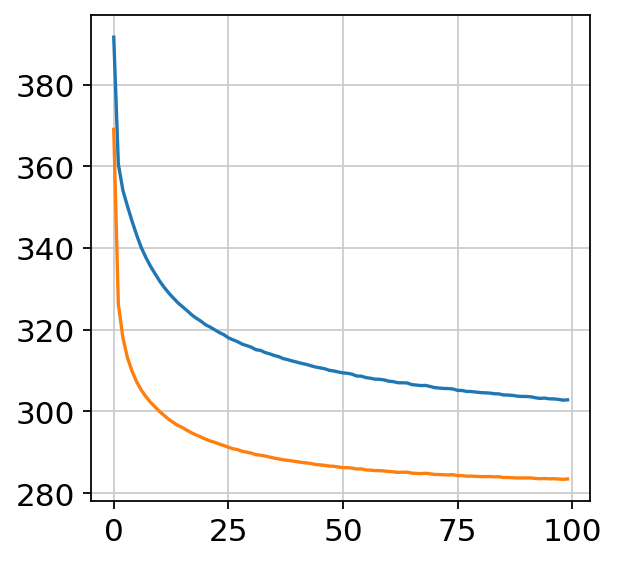

Number of training epochs: 200


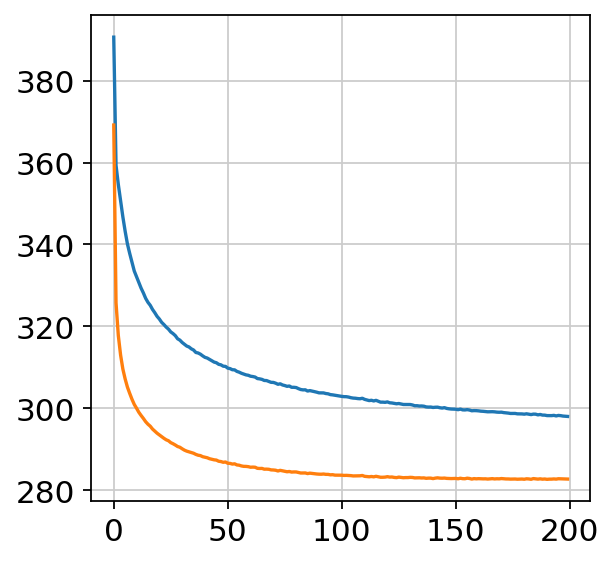

Number of training epochs: 300


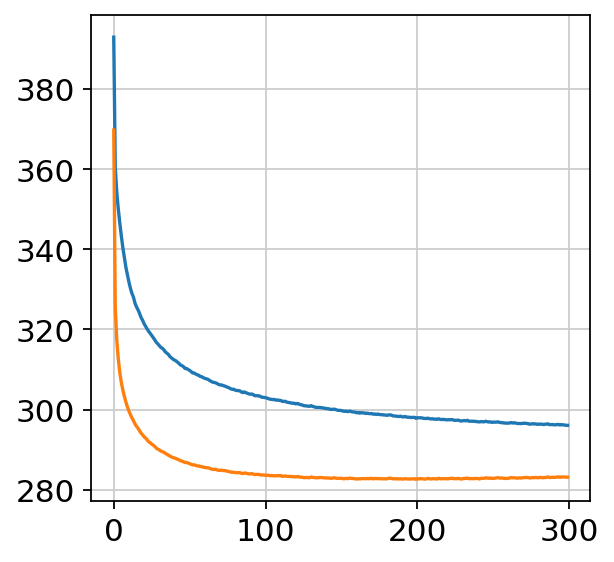

Number of training epochs: 400


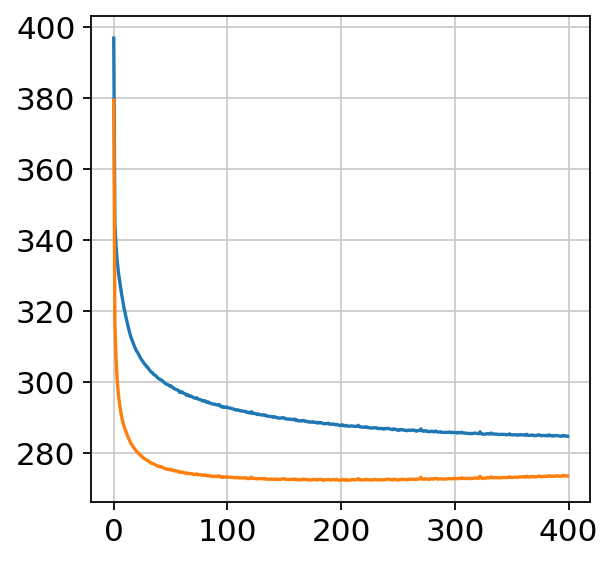

In [4]:
for nepochs, model in models.items():
    print(f"Number of training epochs: {nepochs}")
    plt.plot(model.history["elbo_train"])
    plt.plot(model.history["reconstruction_loss_train"])
    plt.show()

# 2. Creating a signature matrix in latent space 

## 2.0 Latent space representation

In [5]:
def plot_model(models,key):
    model =models[key]
    # Regular scVI
    latent = model.get_latent_representation()
    adata.obsm[f"X_scvi_{key}"] = latent
    
    
    # run PCA then generate UMAP plots
    # sc.tl.pca(adata,use_rep = "X_scvi")
    pca = sc.tl.pca(latent)[:,:2]
    adata.obsm[f"X_pca_{key}"]=pca
    sc.pp.neighbors(adata, use_rep=f"X_scvi_{key}")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type"],
        frameon=False,
    )
    adata.obsm["X_pca"] = pca
    sc.pl.pca(adata,color=["cell_type"])

    

Toy model with 100 epochs


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


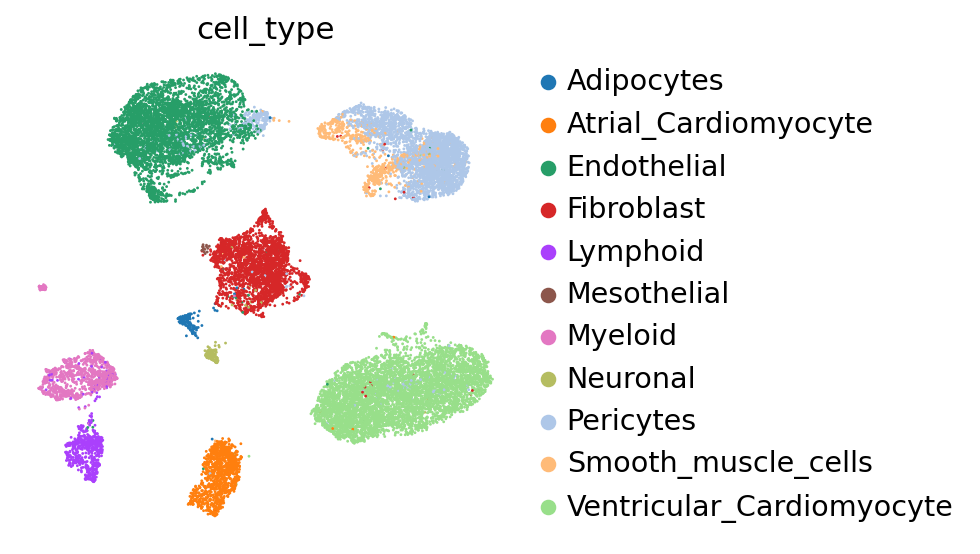

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


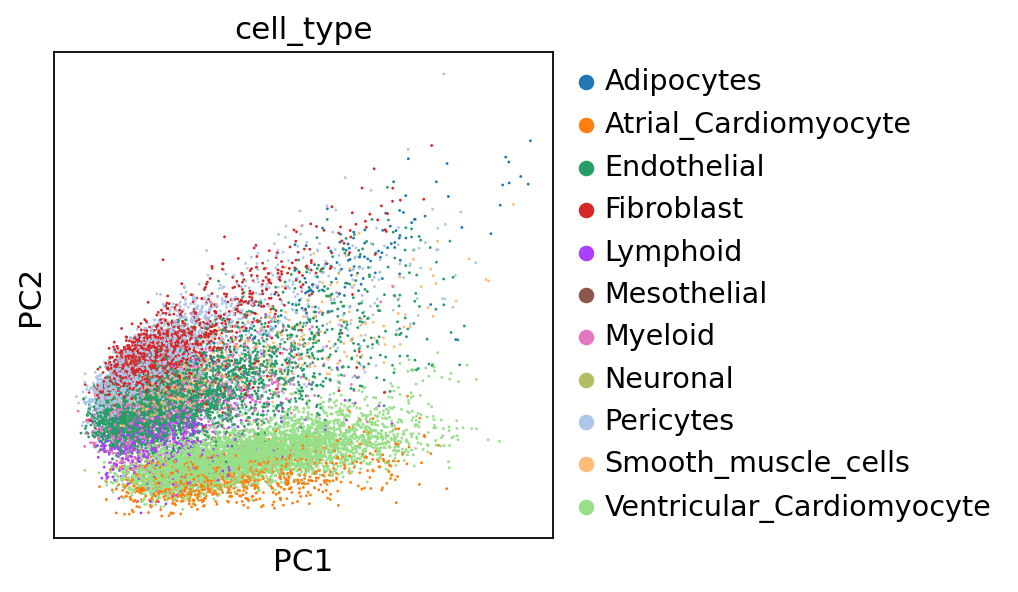

Toy model with 200 epochs


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


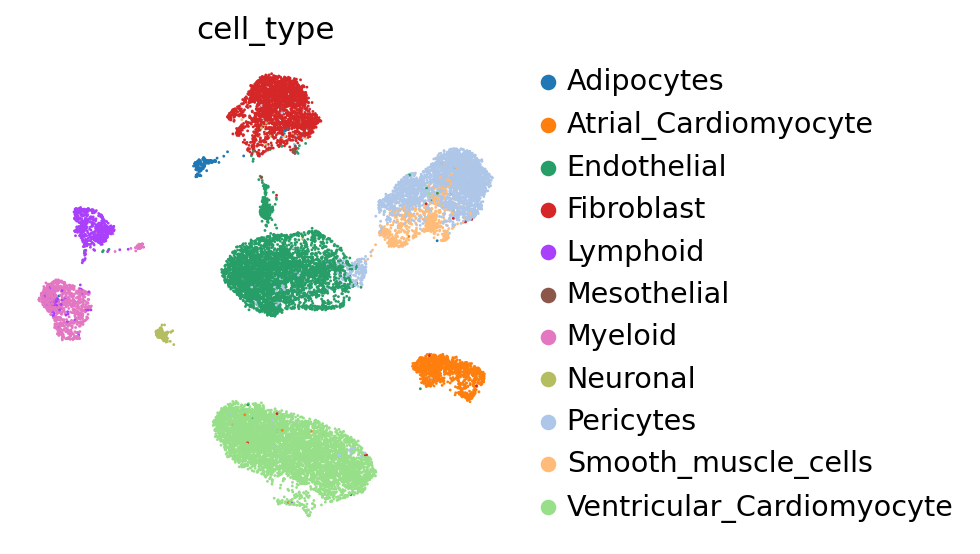

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


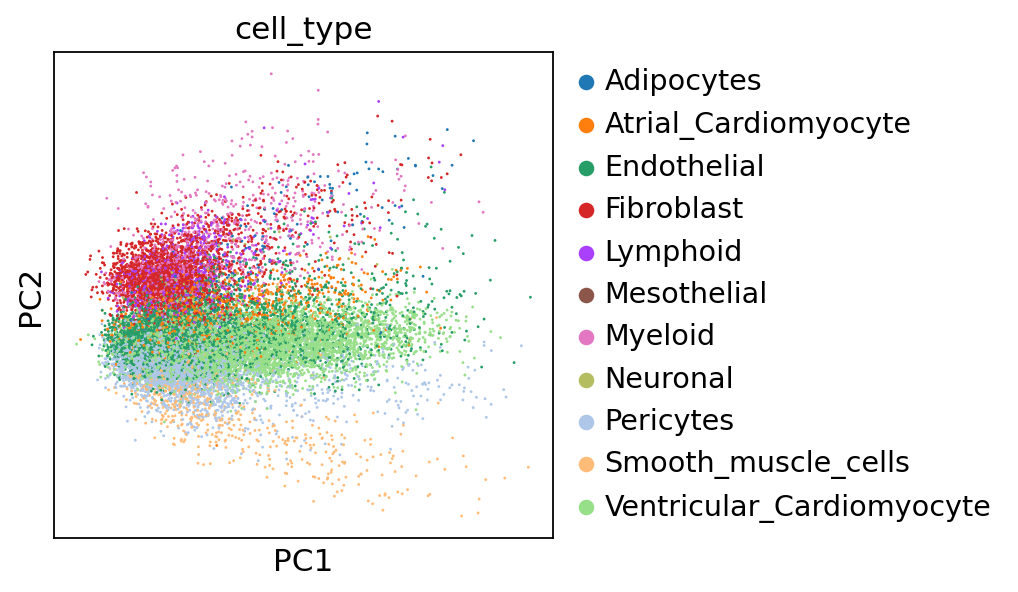

Toy model with 300 epochs


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


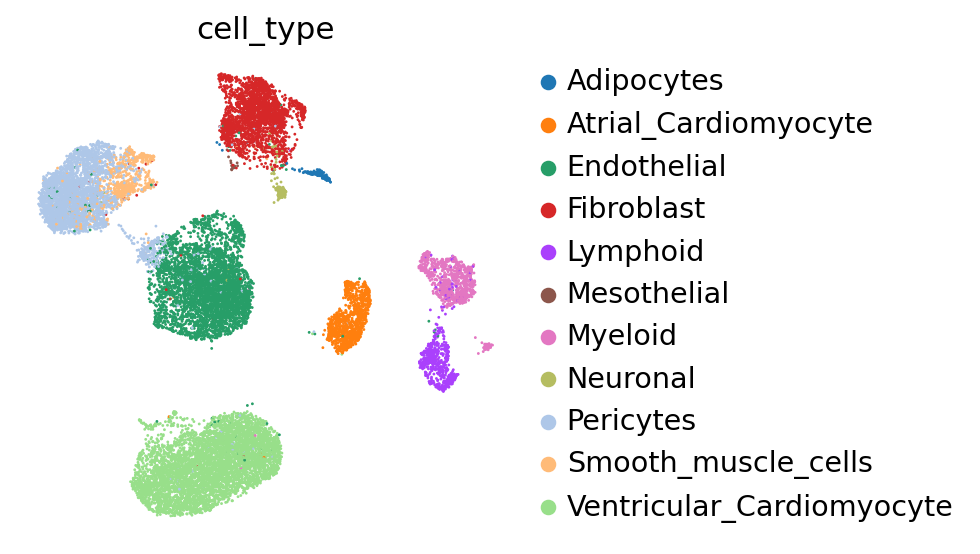

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


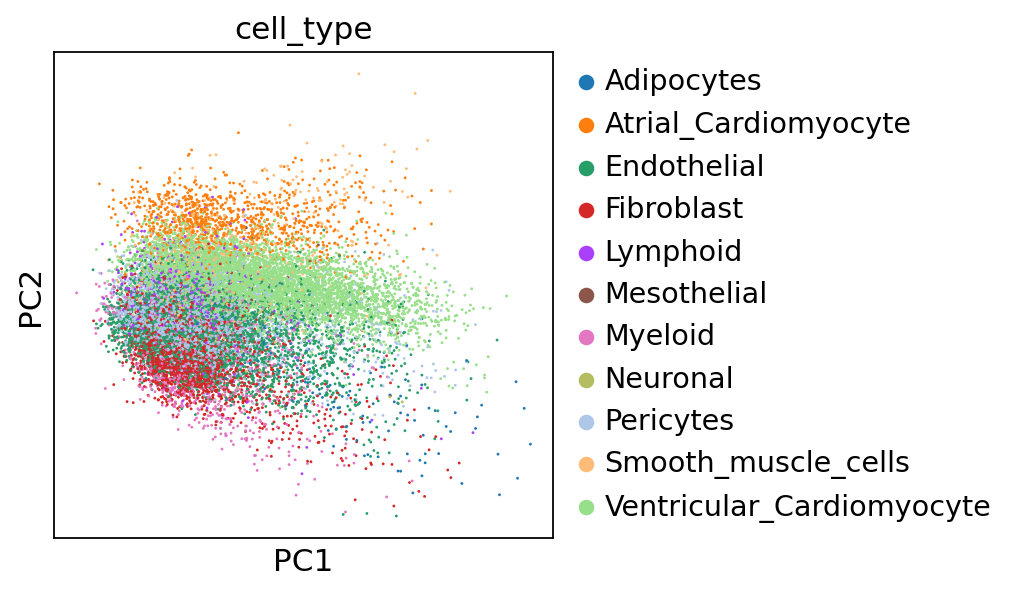

Toy model with 400 epochs


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


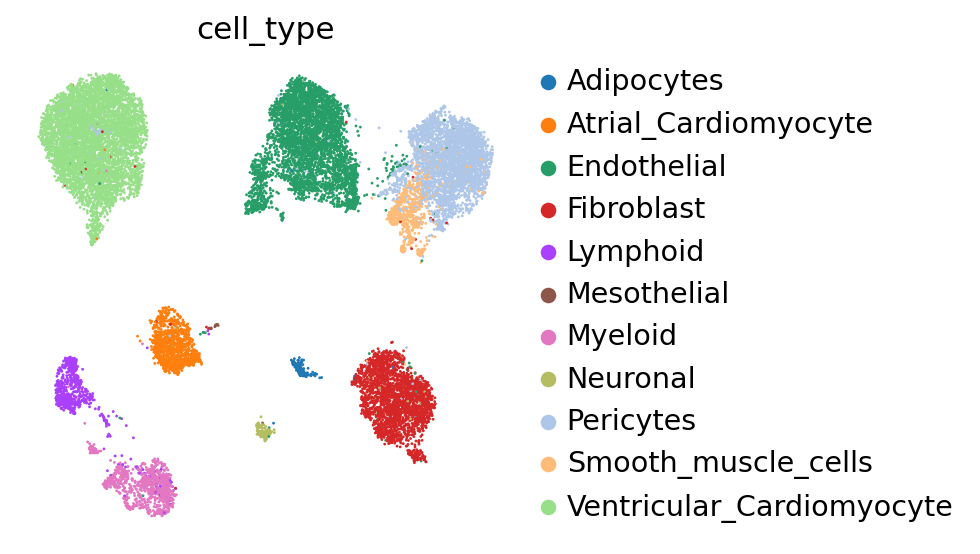

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


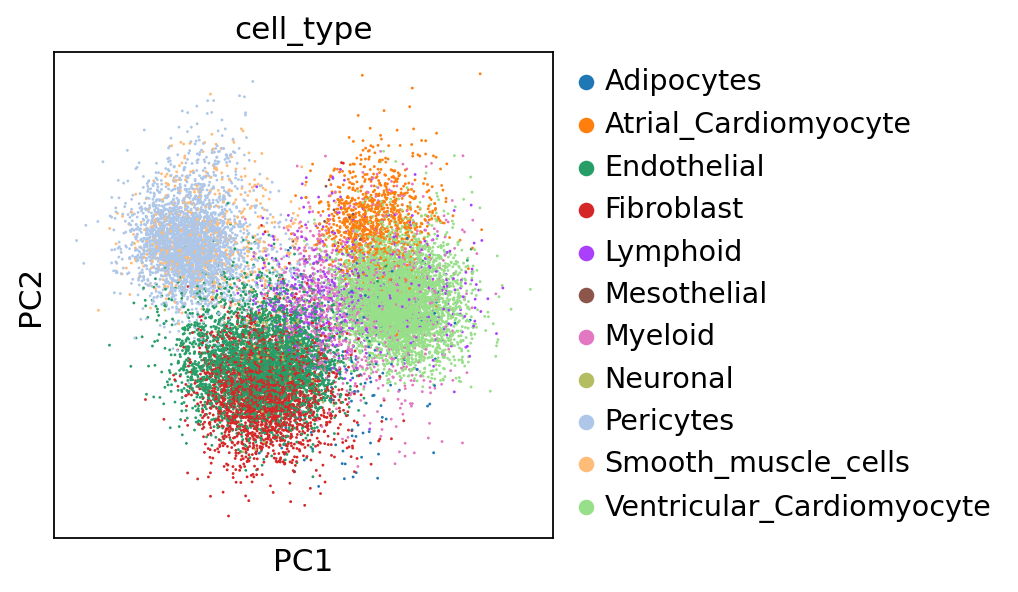

In [6]:
for key in models:
    print(f"Toy model with {key} epochs")
    plot_model(models,key)


## 2.1 Effect of averaging multiple latent representations of single cells 

The goal here is to average multiple latent representations of single cells OF THE SAME CELL TYPE, and see the effect 

In [7]:
from scvi_sanity_checks_utils import create_anndata_pseudobulk
import random
import numpy as np

def make_signature(models,key,adata,number_single_cells,number_repeats,before = True):
    model = models[key]
    cell_type_list = []
    representation_list = []
    for cell_type in adata.obs["cell_type"].unique():
        for repeat in range(number_repeats):
            seed = random.seed()
            sampled_cells = adata.obs[adata.obs['cell_type'] == cell_type].sample(n=number_single_cells,
                                                                                random_state=seed,replace = True).index
            #print(sampled_cells[:5])
            # Select the sampled cells from the DataFrame
            adata_sampled = adata[sampled_cells]
            if before:
                latent_sampled = adata.obsm[f"X_scvi_{key}"]
                result = latent_sampled.mean(axis = 0)
                result = result/np.linalg.norm(result)
            else:
                pseudobulk = adata_sampled.layers["counts"].mean(axis=0).reshape(1,-1) #.astype(int).astype(numpy.float32)
                adata_pseudobulk = create_anndata_pseudobulk(adata_sampled, pseudobulk)
                result = model.get_latent_representation(adata_pseudobulk).reshape(-1)
            representation_list.append(result)
            cell_type_list.append(cell_type)
    full_rpz = np.stack(representation_list,axis=0)
    signature_sampled= ad.AnnData(X=full_rpz,obs=pd.DataFrame(pd.Series(cell_type_list,name="cell type")))
    return signature_sampled
                
                
            
            
    
    
    
    
    

### 2.1.1 Test if the function works to build signatures

In [15]:
signature_sampled = make_signature(models,400,adata,1000,5,before = False)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 1 in adata.obs['cell_source'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 5 in adata.obs['donor'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

In [16]:
signature_sampled.obs["cell type"].unique()

array(['Myeloid', 'Ventricular_Cardiomyocyte', 'Fibroblast',
       'Endothelial', 'Adipocytes', 'Pericytes', 'Atrial_Cardiomyocyte',
       'Smooth_muscle_cells', 'Neuronal', 'Lymphoid', 'Mesothelial'],
      dtype=object)

In [17]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_sampled, use_rep="X")
sc.tl.umap(signature_sampled, min_dist=0.3)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


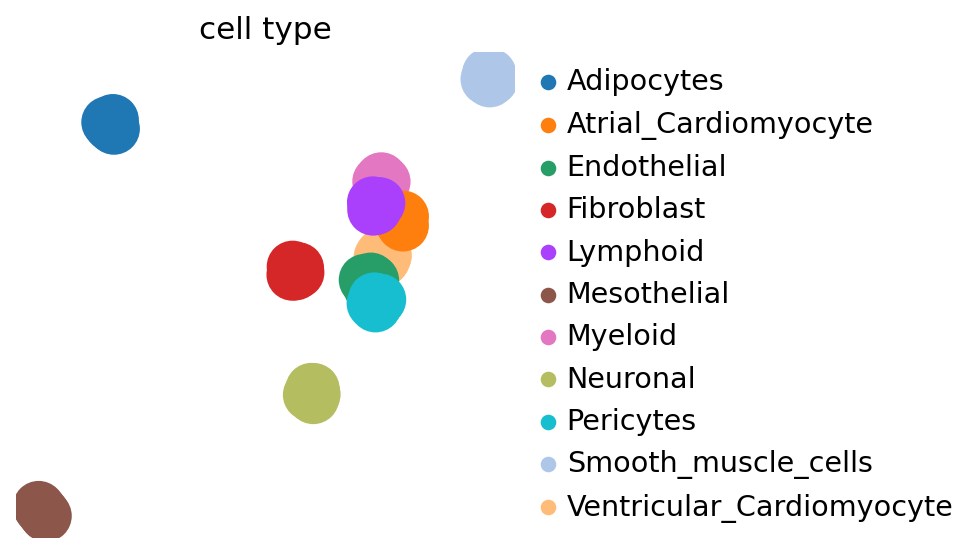

In [18]:
sc.pl.umap(
    signature_sampled,
    color = ["cell type"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


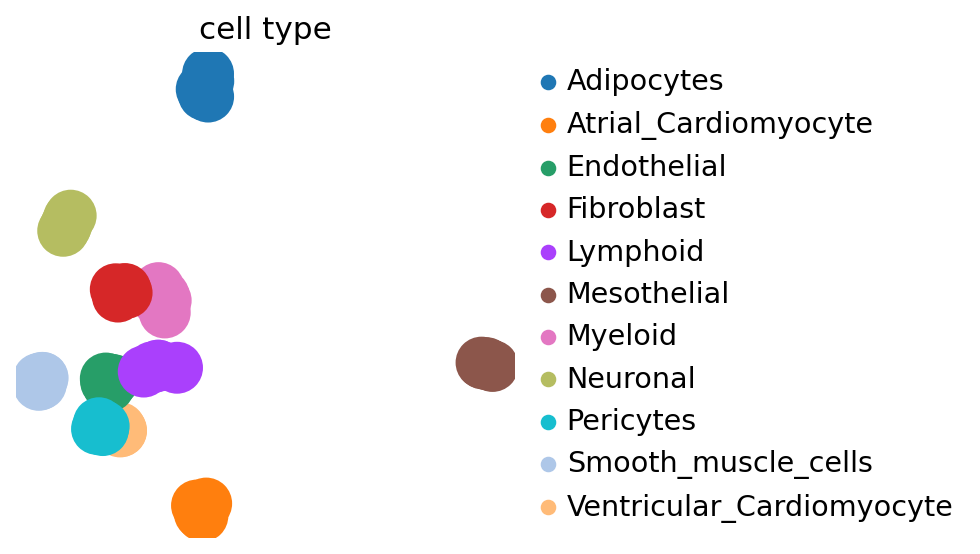

In [19]:
sc.tl.pca(signature_sampled)
sc.pl.pca(
    signature_sampled,
    color = ["cell type"],
    frameon=False,
)

### 2.1.2 Creating signatures 

In [8]:
signatures = {}
for key in models:
    signatures[key] = make_signature(models,key,adata,1000,1,before = False)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: U

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

## 2.2 Scalar multiplication effect

## 2.3 Testing signature 

In [9]:
def create_bulk_embedding_from_proportions(models,key,adata,proportions,total_cells= 11000):
    model = models[key]
    sampled_cells_per_type = proportions * total_cells
    sampled_cells_per_type = sampled_cells_per_type.astype(int)

    cell_types = list(adata.obs['cell_type'].unique())
    sampled_cells = []
    # Perform stratified sampling for each cell type
    sampled_cells = []
    for index_ct,ct, in enumerate(cell_types):
        seed = random.seed()
        num_cells = sampled_cells_per_type[index_ct]
        sampled_cells.extend(adata.obs[adata.obs['cell_type'] == ct].sample(n=num_cells,
                                                                                random_state=seed,replace = True).index)
    adata_sampled = adata[sampled_cells]
    pseudobulk = adata_sampled.layers["counts"].mean(axis=0).reshape(1,-1) #.astype(int).astype(numpy.float32)
    adata_pseudobulk = create_anndata_pseudobulk(adata_sampled, pseudobulk)
    result = model.get_latent_representation(adata_pseudobulk).reshape(-1)
    return result

In [10]:
def create_proportion(n_non_zero = 2):
    gt_prop = np.zeros(11,)
    
    gt_prop[:n_non_zero] = np.random.rand(n_non_zero) 
    
    gt_prop = gt_prop/gt_prop.sum()
    return np.random.permutation(gt_prop)

In [11]:
from scipy.optimize import nnls
from scipy.stats import pearsonr




def make_corrs_error(models,signatures,adata,n_non_zero,total_cells= 11000, repeats = 10):
    nmodels = len(list(models.keys()))
    result = np.zeros((nmodels,repeats))
    for i,key in enumerate(list(models.keys())):
        signature= signatures[key].X.T
        for repeat in range(repeats):
            prop = create_proportion(n_non_zero)
            bulk_embedding = create_bulk_embedding_from_proportions(models,key,adata,prop,total_cells= total_cells)
            predprop = nnls(signature,bulk_embedding)[0]
            predprop = predprop/predprop.sum()
            result[i,repeat] = np.dot(prop,predprop)/np.linalg.norm(prop) / np.linalg.norm(predprop)

    return result
            
            
        
        
        
        
    

In [44]:
# Function test
# res = make_corrs_error(models,signatures,adata,3,total_cells= 11000, repeats = 10)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

### 2.3.1 Deconvolution on pseudobulks as a function of the number of cell types in the mixture

In [12]:
res_global = {}
for k in range(1,9):
    res_global[k] = make_corrs_error(models,signatures,adata,k,total_cells= 11000, repeats = 20)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 1 in adata.obs['cell_source'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 5 in adata.obs['donor'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[c

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 3 in adata.obs['cell_source'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 5 in adata.obs['donor'] 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 3 in adata.obs['cell_source'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 1 in adata.obs['donor'] 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['cell_source'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 5 in adata.obs['donor'] 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 0 in adata.obs['cell_source'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 5 in adata.obs['donor'] 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 3 in adata.obs['cell_source'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 1 in adata.obs['donor'] 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

#### Plots as a function of the number of epochs

/tmp/ipykernel_9677/3197007068.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(list(models.keys()),
/tmp/ipykernel_9677/3197007068.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(list(models.keys()),


Text(0.5, 1.0, 'Sanity check : simple deconvolution of mixtures using built signature.')

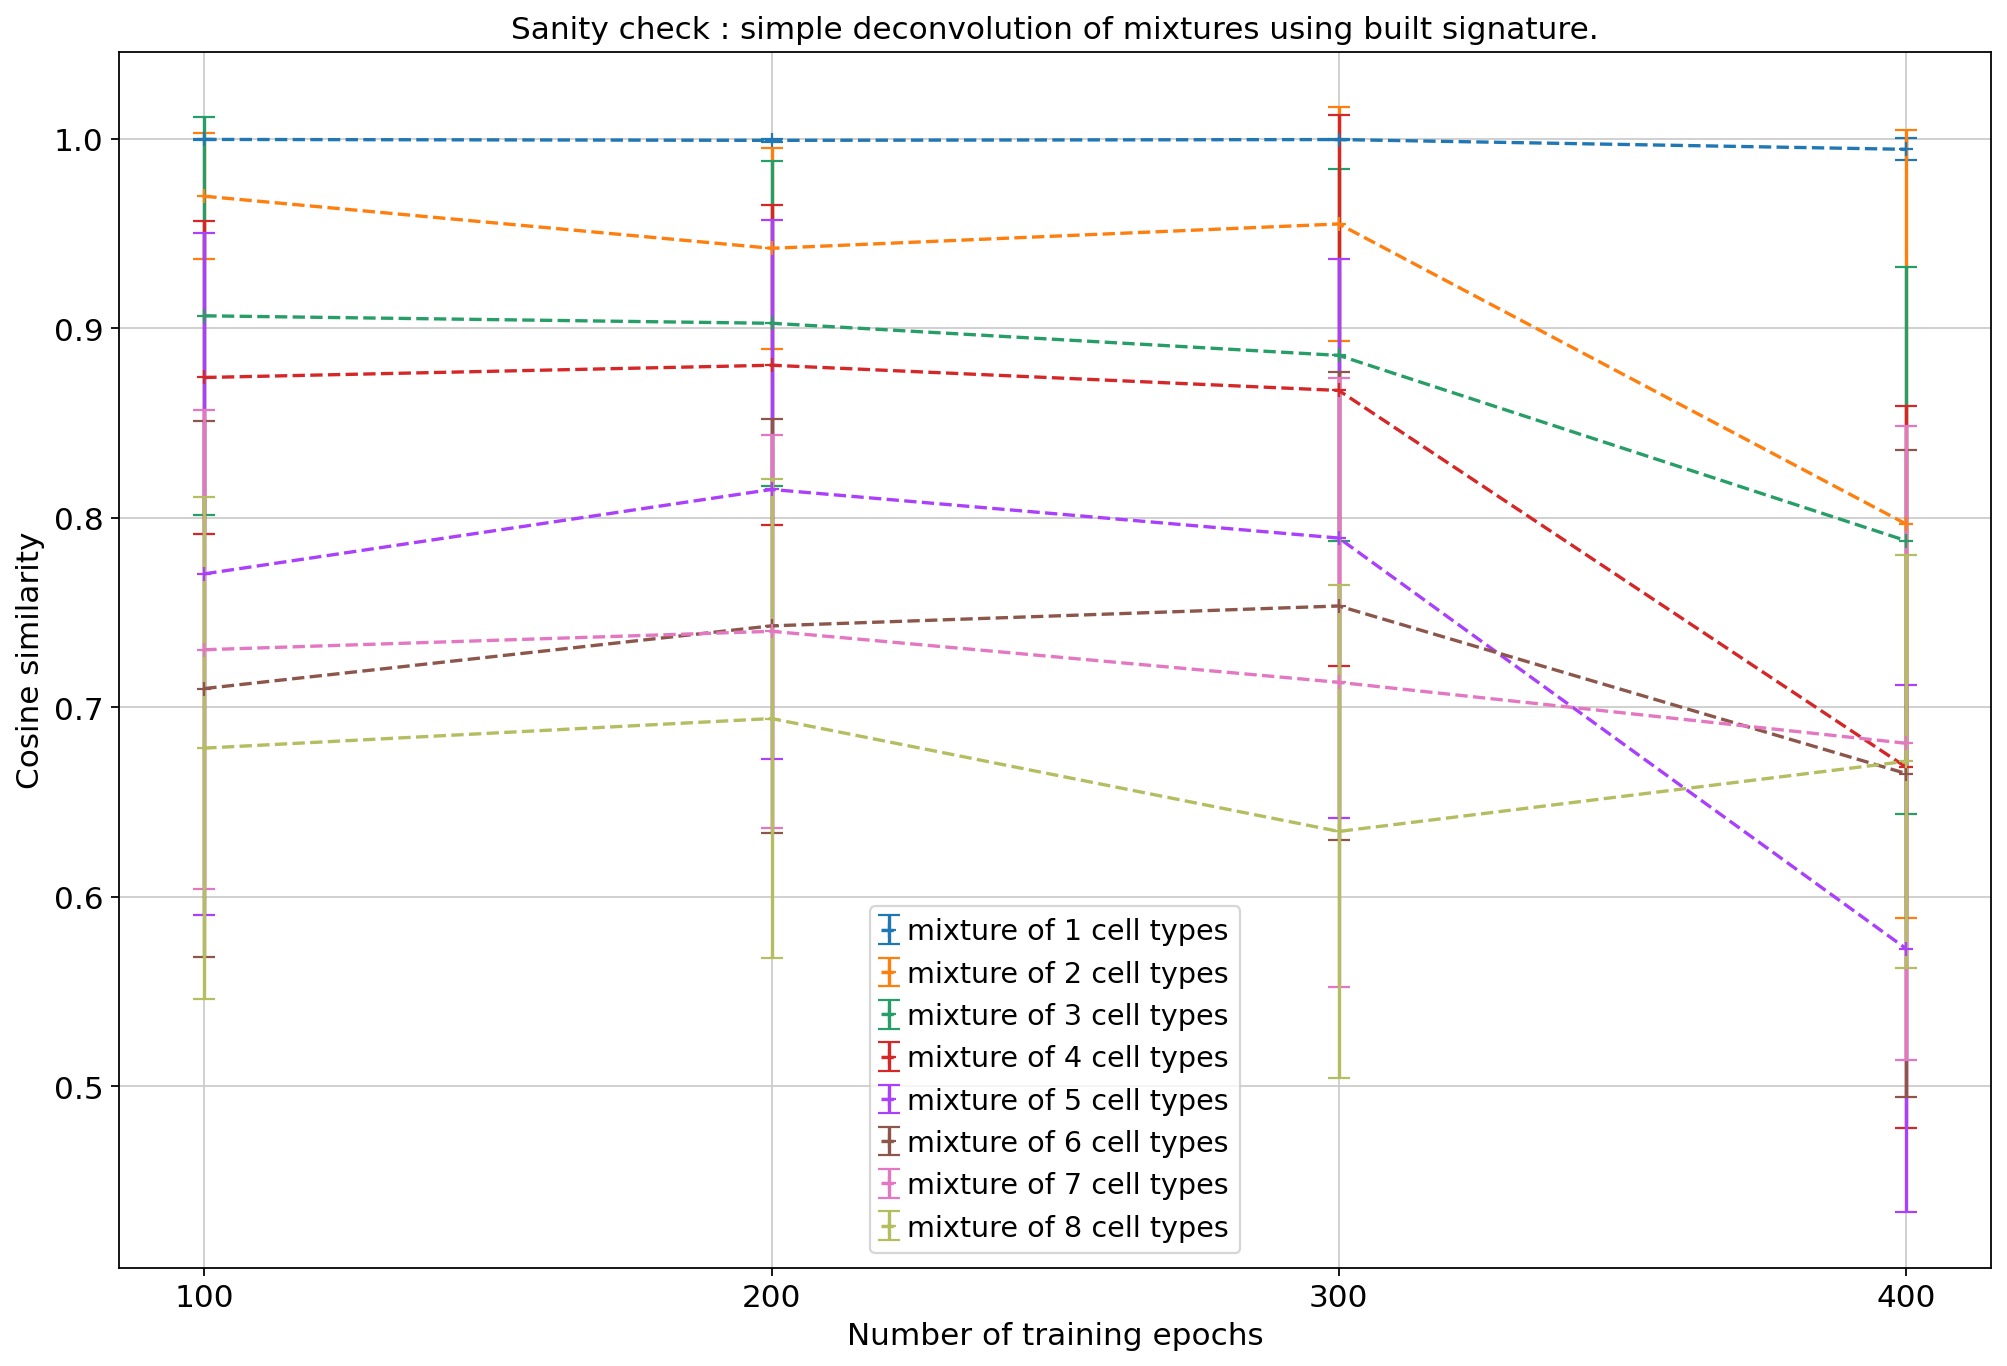

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for nonzero,res in res_global.items():
        plt.errorbar(list(models.keys()),
                res.mean(axis=1),
                yerr=np.std(res,axis=1),
                fmt='o-',
                capsize=5,
                linestyle="--", marker="+",
                label=f"mixture of {nonzero} cell types")

    
plt.legend()  
plt.xlabel("Number of training epochs")
plt.ylabel("Cosine similarity")
plt.xticks(list(models.keys()))

plt.title("Sanity check : simple deconvolution of mixtures using built signature.")

#### Plot as a function of the number of mixtures

In [16]:
result_by_epochs = {}
for i,nepochs in enumerate( list(models.keys())):
    n_repeats = res_global[1].shape[1]
    array_for_nepoch = np.zeros((8,n_repeats))
    for n_mixture in range(1,9):
        for j in range(n_repeats):
            array_for_nepoch[n_mixture-1,j] = res_global[n_mixture][i,j]
    result_by_epochs[nepochs]= array_for_nepoch
        
        
    


/tmp/ipykernel_9677/2077011729.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(list(range(1,9)),
/tmp/ipykernel_9677/2077011729.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(list(range(1,9)),


Text(0.5, 1.0, 'Sanity check : simple deconvolution of mixtures using built signature.')

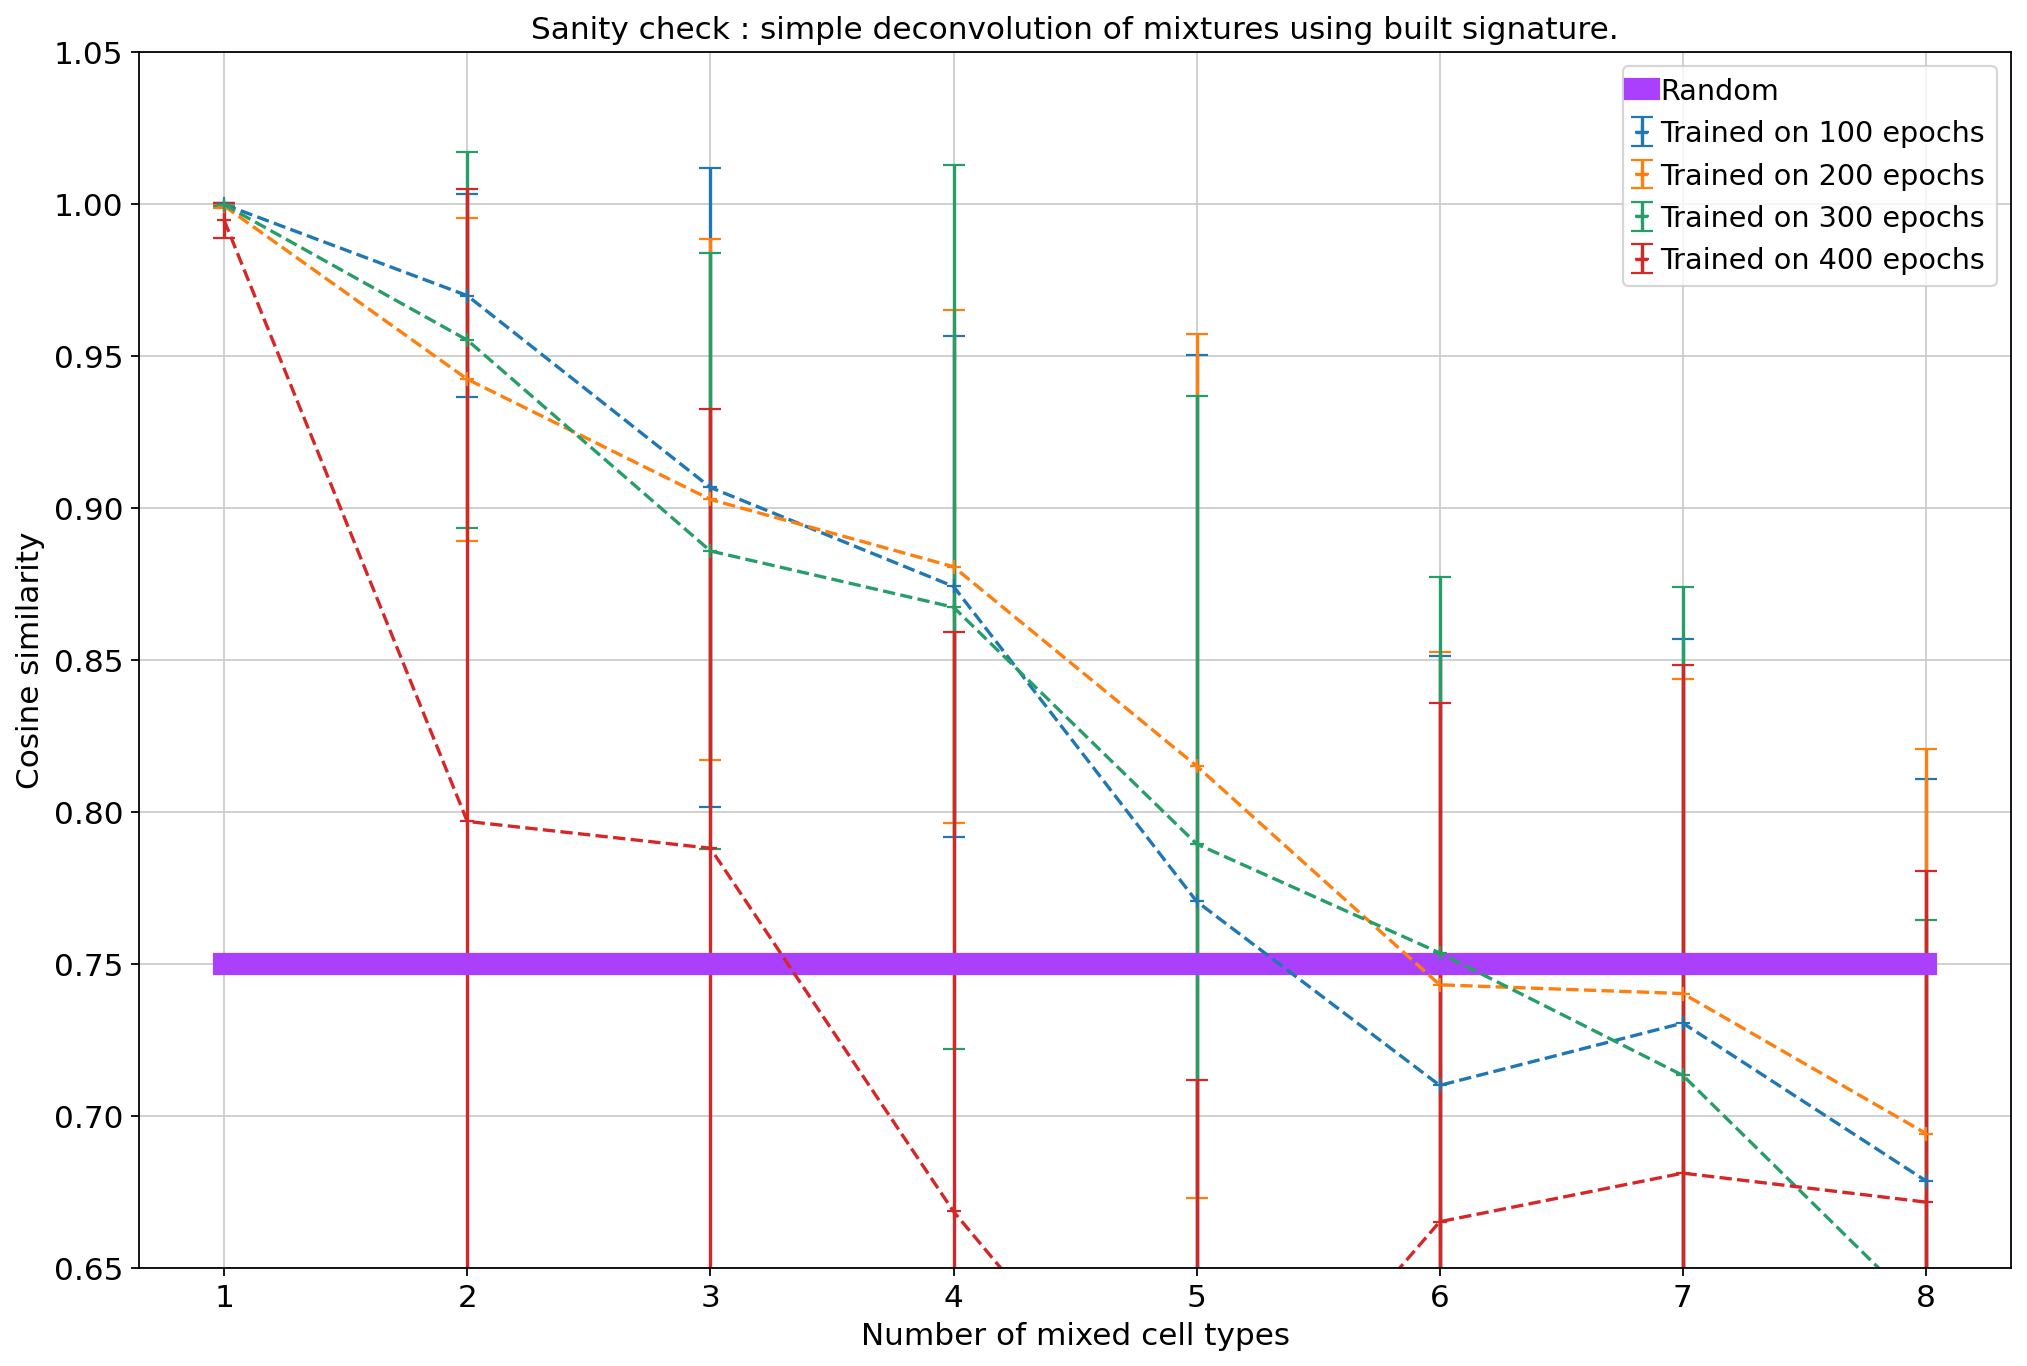

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for nepochs,res in result_by_epochs.items():
        plt.errorbar(list(range(1,9)),
                res.mean(axis=1),
                yerr=np.std(res,axis=1),
                fmt='o-',
                capsize=5,
                linestyle="--", marker="+",
                label=f"Trained on {nepochs} epochs")

plt.plot(list(range(1,9)),[0.75]*8,linewidth=10,label = "Random")   
plt.ylim(0.65,1.05)
plt.legend()  
plt.xlabel("Number of mixed cell types")
plt.ylabel("Cosine similarity")
plt.xticks(list(range(1,9)))

plt.title("Sanity check : simple deconvolution of mixtures using built signature.")

In [22]:
N = 100
hihi = np.zeros(N)
for k in range(N):
    
    v1 = np.random.rand(11)
    v2 = np.random.rand(11)
    v1 = v1/v1.sum()
    v2 = v2/v2.sum()
    hihi[k] = np.dot(v1,v2)/np.linalg.norm(v1) / np.linalg.norm(v2)

print("Randomness would give ",hihi.mean())

Randomness would give  0.7394849257195737


In [23]:
hihi

array([0.83183294, 0.81338252, 0.67829763, 0.65119024, 0.86532223,
       0.91875286, 0.80667471, 0.71191953, 0.88829362, 0.7371841 ,
       0.6169236 , 0.68865699, 0.68760711, 0.3424384 , 0.76859904,
       0.83537829, 0.68547864, 0.7123654 , 0.7855518 , 0.56892708,
       0.86800276, 0.7073897 , 0.88352633, 0.8574232 , 0.81564374,
       0.68029196, 0.83735291, 0.67952578, 0.69448855, 0.58222907,
       0.6705159 , 0.6950341 , 0.87166689, 0.79248472, 0.78437185,
       0.83022785, 0.73739022, 0.67773277, 0.80697703, 0.74330272,
       0.79932405, 0.68048949, 0.86165891, 0.89172883, 0.69380841,
       0.81256531, 0.48037474, 0.84596954, 0.74870655, 0.81423324,
       0.80506252, 0.83409934, 0.63039316, 0.62521094, 0.77093226,
       0.715788  , 0.88339468, 0.76596661, 0.80045475, 0.55121181,
       0.75389538, 0.81870538, 0.57615909, 0.84930553, 0.65803587,
       0.65553568, 0.84704107, 0.84675495, 0.47804423, 0.886084  ,
       0.76514042, 0.71144285, 0.7801619 , 0.64811331, 0.83107

# OLD

In [24]:
gt_prop = np.zeros(11,)
n_rand = 3
gt_prop[:n_rand] = np.random.rand(n_rand) 

gt_prop = gt_prop/gt_prop.sum()

key = 100
bulk_example = create_bulk_embedding_from_proportions(models,key,adata,gt_prop,total_cells= 11000)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/owkin/ngot_wp_2/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category

In [25]:
print(gt_prop)

[0.00700835 0.57472435 0.4182673  0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [26]:
signature_example.shape

(11, 10)

In [27]:
signature_example

AnnData object with n_obs × n_vars = 11 × 10
    obs: 'cell type'

In [28]:
from scipy.optimize import nnls
v = nnls(signature_example.X.T,bulk_example)[0]
v = v/v.sum()

In [29]:
v.dot(gt_prop)

0.47712732566045196

In [30]:
from scipy.stats import pearsonr

pearsonr(v,gt_prop)

PearsonRResult(statistic=0.997655987124848, pvalue=8.52660743237499e-12)

In [155]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_adata, use_rep="X")
sc.tl.umap(signature_adata, min_dist=0.3)

NameError: name 'signature_adata' is not defined

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


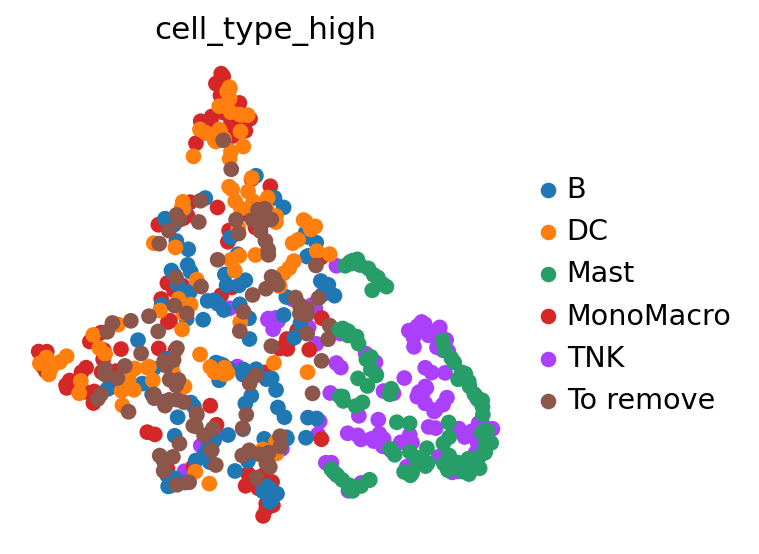

In [23]:
sc.pl.umap(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


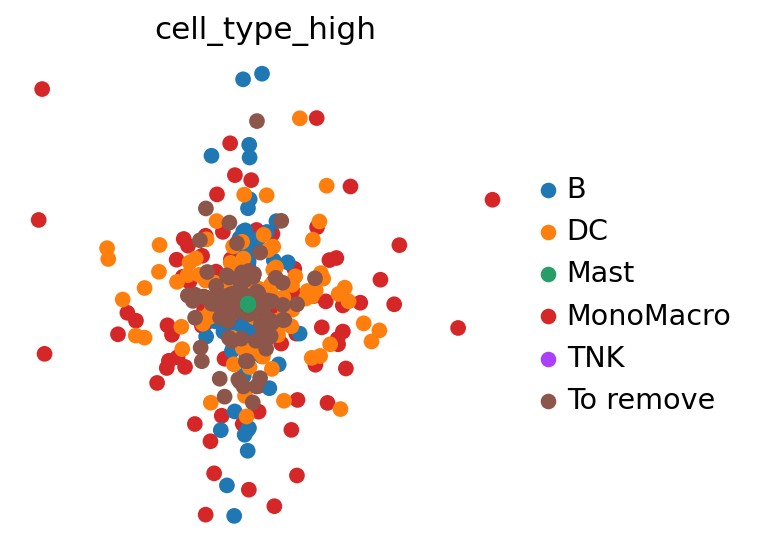

In [25]:
sc.tl.pca(signature_adata, svd_solver='arpack')
sc.pl.pca(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

In [22]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_adata, use_rep="X")
sc.tl.umap(signature_adata, min_dist=0.3)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


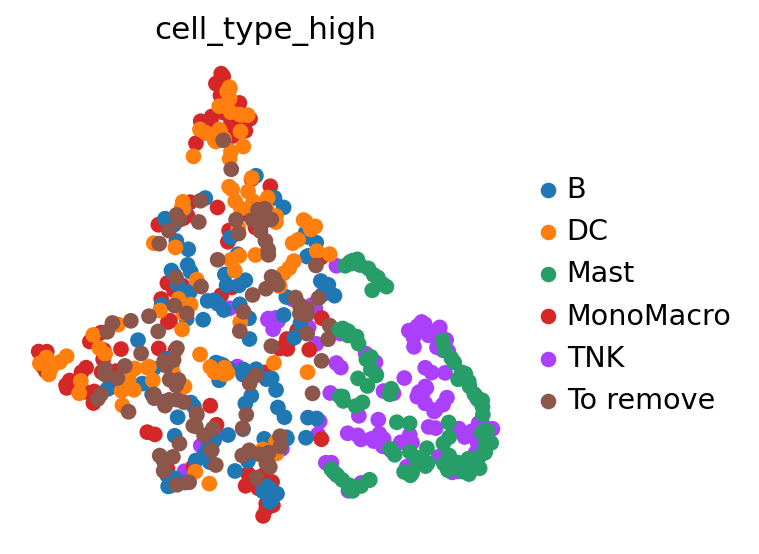

In [23]:
sc.pl.umap(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


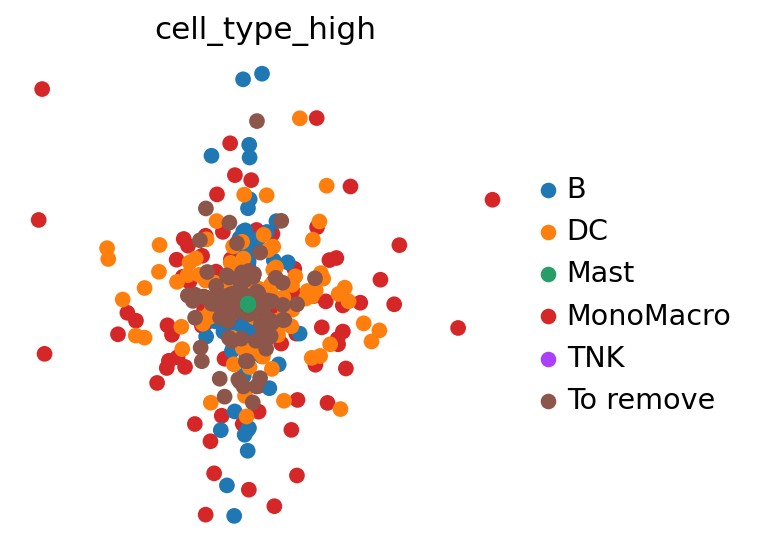

In [25]:
sc.tl.pca(signature_adata, svd_solver='arpack')
sc.pl.pca(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

# 2. Creating a signature matrix in latent space 

In [18]:
import random
from scipy.stats import pearsonr
import numpy as np

df_signature_denoised = pd.DataFrame()

num_cells = 1000
num_repeats = 100

dico_rpz = {}


for cell_type in adata.obs["cell_types_grouped"].unique():
        dico_rpz[cell_type] = []
        for repeat in range(num_repeats):
            seed = random.seed()
            sampled_cells = adata.obs[adata.obs['cell_types_grouped'] == cell_type].sample(n=num_cells,
                                                                                random_state=seed,replace = True).index
            #print(sampled_cells[:5])
            # Select the sampled cells from the DataFrame
            adata_sampled = adata[sampled_cells]
    
            # embeddings of single-cells
            # latent_sampled = model.get_latent_representation(adata_sampled)
            latent_sampled = model.module.z_encoder(torch.from_numpy(adata_sampled.layers["counts"].toarray()).to("cuda:0"))[1]
            # normalize in 1 direction 
            
            latent_sampled = latent_sampled.detach().cpu().numpy()

            correct = ((-np.inf < latent_sampled) *(latent_sampled < np.inf) * (1 - np.isnan(latent_sampled))).astype(bool)
            incorrect = (1-correct).astype(bool)
            
            number_incorrect = np.sum(incorrect)

            latent_sampled[incorrect] = 0.

            #latent_sampled[correct] = latent_sampled[correct] / np.abs(latent_sampled[correct]).sum(axis = 1)

            dim1_loc,dim2_loc = np.where(incorrect)
            latent_sampled[incorrect] = np.mean(latent_sampled[:,dim2_loc],axis=0)

            #if number_incorrect > 0:
                #print(f"For cell type {cell_type}, repeat {repeat+1}:")
                #print("Number of nans, infinities etc", np.sum(1-correct))
            

            mean_sampled_z = np.mean(latent_sampled,axis=0)
            dico_rpz[cell_type].append(mean_sampled_z.copy())
            




In [ ]:
def sanity_checks_metrics(model: scvi.model.SCVI,
                          adata: ad.AnnData,
                          batch_sizes: List[int],
                          n_repeats: int,
                          use_get_latent: bool=True) -> Dict:
    """Computes sanity check metrics for a given scVI model.

    Parameters
    ----------
    model: scvi.model.SCVI
        fitted scvi model
    adata: ad.AnnData
        Anndata object sotring the training set
    batch_sizes: List[int]
        List of batch size (# on sampled cells)
    n_repeats: int
        Number of repeats
    use_get_latent: bool
        Whether to use get_latent scvi built in function
        to infer the latent states. Is set to `False`, will
        use the module encoder directly.

    Returns
    -------
    Dict
        Dictionnary storing latent space metrics
    """
    metrics = {"corr": [], "kl": []}
    errors = {"corr": [], "kl": []}
    for n in tqdm.tqdm(batch_sizes):
        current_metrics = {"corr": [], "kl": []}
        for i in range(n_repeats):
            # Calculate the number of cells to sample from each cell type proportionally
            sampled_cells_per_type = adata.obs['cell_type'].value_counts(normalize=True) * n
            sampled_cells_per_type = sampled_cells_per_type.astype(int)

            # Perform stratified sampling for each cell type
            sampled_cells = []
            for cell_type, num_cells in sampled_cells_per_type.items():
                seed = random.seed()
                sampled_cells.extend(adata.obs[adata.obs['cell_type'] == cell_type].sample(n=num_cells,
                                                                                        random_state=seed).index)

            # Select the sampled cells from the DataFrame
            adata_sampled = adata[sampled_cells]

            # embeddings of single-cells
            if use_get_latent:
                latent_sampled = model.get_latent_representation(adata_sampled)
                mean_sampled_z = latent_sampled.mean(axis=0)
            else:
                dist_z, latent_sampled = model.module.z_encoder(torch.from_numpy(adata_sampled.layers["counts"].toarray()).to("cuda:0"))
                latent_sampled = latent_sampled.detach().cpu().numpy()
                mean_sampled_z = latent_sampled.mean(axis=0)
                mean_sampled_z = replace_inf(mean_sampled_z)

            # pseudo-bulk embedding
            if use_get_latent:
                pseudobulk_x = adata_sampled.layers["counts"].mean(axis=0) #.astype(int).astype(numpy.float32)
                adata_pseudobulk = create_anndata_pseudobulk(adata, pseudobulk_x)
                pseudobulk_z = model.get_latent_representation(adata_pseudobulk)
            else:
                dist_pseudobulk_z, pseudobulk_z = model.module.z_encoder(torch.from_numpy(pseudobulk_x).to("cuda:0"))
                pseudobulk_z = pseudobulk_z.detach().cpu().numpy().flatten()

                pseudobulk_z = replace_inf(pseudobulk_z)

            # Compute correlation
            print(mean_sampled_z.shape)
            print(pseudobulk_z.shape)
            pearson_corr = pearsonr(mean_sampled_z, pseudobulk_z.flatten())
            current_metrics["corr"].append(pearson_corr[0])

            # compute kl-divergence
            # kl = kl_divergence(dist_z,
            #                    dist_pseudobulk_z).sum(dim=-1)


        metrics["corr"].append(np.mean(current_metrics["corr"]))
        errors["corr"].append(np.std(current_metrics["corr"]))

    return metrics, errors

In [19]:
dico_rpz

{'TNK': [array([-1.9922867e+01,  2.1871547e+14,  1.7819394e+07,  1.4922597e+14,
          1.1870529e+04,  1.0149220e+04, -5.3096249e+01, -8.7627120e+06,
          2.8414688e+05,  2.2017326e+07], dtype=float32),
  array([-2.3719242e+01,  2.5215778e+07, -7.2367317e+01, -1.7861593e+11,
         -1.8990986e+01, -3.0718470e+01, -2.1324116e+01,  5.6106430e+01,
         -2.0845821e+01, -6.1168906e+05], dtype=float32),
  array([-1.6716018e+03, -2.5294189e+10,  5.7863052e+03,  4.1671144e+12,
          5.4867542e+02, -2.3528543e+01, -3.1620293e+01,  1.9016840e+04,
         -1.7034558e+03,  2.0341639e+10], dtype=float32),
  array([ 2.9831161e+12,  2.1570470e+11,  3.5568944e+08, -2.4827864e+14,
          9.9324150e+01, -3.6306638e+05, -2.0778410e+01,  6.1469562e+08,
         -5.8247115e+10, -7.0415754e+14], dtype=float32),
  array([ 6.6577216e+08, -4.1749065e+06, -6.5510069e+12,  1.3169245e+11,
          7.4187237e-01,  1.8813007e+02, -2.1568308e+01, -1.8209080e+13,
          1.9379490e+08, -7.085

In [20]:
obs = []
matrices = []
for key,value in dico_rpz.items():
    for repeat, repeat_rpz in enumerate(value):
        obs.append(key)
        matrices.append(repeat_rpz)
X = np.stack(matrices)

signature_adata = ad.AnnData(X= X, obs=obs )

In [21]:
signature_adata.obs["cell_type_high"] = signature_adata.obs[0]

In [22]:
# run PCA then generate UMAP plots
sc.pp.neighbors(signature_adata, use_rep="X")
sc.tl.umap(signature_adata, min_dist=0.3)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


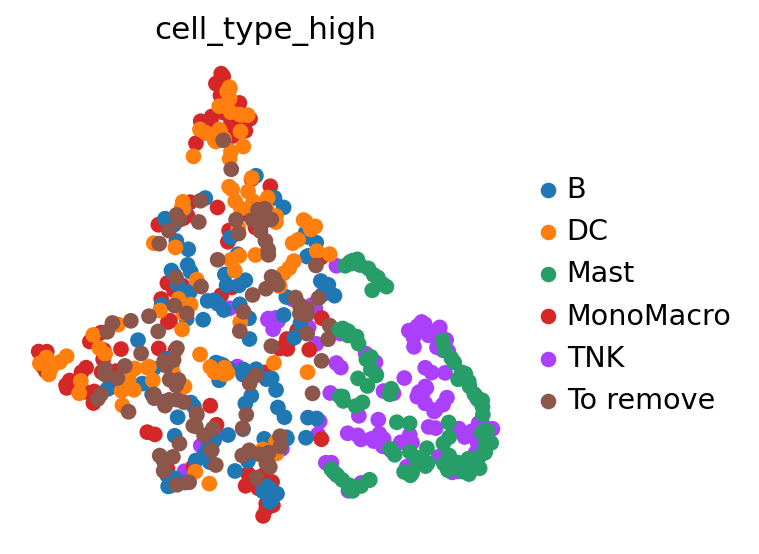

In [23]:
sc.pl.umap(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


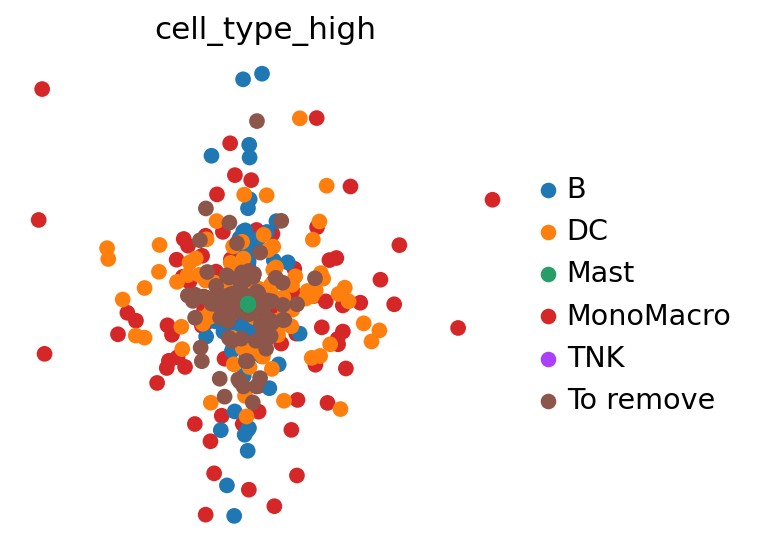

In [25]:
sc.tl.pca(signature_adata, svd_solver='arpack')
sc.pl.pca(
    signature_adata,
    color = ["cell_type_high"],
    frameon=False,
)

In [17]:
means = []
stds = []
for cell_type in signature_adata.obs["cell_type_high"].unique():
    means.append(signature_adata[signature_adata.obs['cell_type_high'] == cell_type].X.mean(axis = 0))
    stds.append(signature_adata[signature_adata.obs['cell_type_high'] == cell_type].X.std(axis = 0))
    

In [93]:
means

[array([ 2.67881651e+12, -1.09729175e+14, -8.79701745e+13,  1.16617002e+14,
        -1.66037216e+02, -2.42745953e+05, -5.60644897e+02,  5.42639791e+14,
        -4.70940228e+12,  5.79052084e+12], dtype=float32),
 array([ 7.7623159e+14, -5.6130864e+14,  5.7545307e+11, -8.5559859e+13,
        -3.1582249e+01, -6.2986451e+08, -6.3841412e+01, -7.6830883e+13,
         2.9311578e+14, -8.7500812e+14], dtype=float32),
 array([-1.2462461e+15,  1.3316133e+15,  4.0329280e+14, -2.3088950e+15,
        -4.8132027e+14,  1.1973579e+14, -5.7612805e+14,  7.3256224e+14,
        -2.5258703e+14, -1.2745318e+14], dtype=float32),
 array([ 2.3130350e+11,  1.6319539e+14, -2.4973148e+13, -2.4063779e+14,
        -5.1523027e+00,  2.2369141e+03, -2.0954397e+08,  9.2423200e+14,
         4.8812976e+11,  1.8245165e+15], dtype=float32),
 array([ 6.76906307e+13, -1.43131074e+15, -1.49455467e+14, -8.89987151e+14,
         1.72576114e+14,  3.39767040e+13,  2.05914322e+12,  1.28554277e+14,
        -1.60275701e+13,  1.027777

In [94]:
stds

[array([8.0004965e+12, 5.3537495e+14, 2.6651978e+14, 3.2966991e+14,
        8.7576251e+02, 7.5843681e+05, 1.8110043e+04, 1.7367667e+15,
        1.3094419e+13, 1.1164624e+14], dtype=float32),
 array([2.8936886e+15, 9.1218942e+15, 1.3319478e+14, 5.7436227e+15,
        7.2230536e-01, 4.6351954e+09, 7.5747585e-01, 3.5121806e+14,
        9.4777916e+14, 5.5151009e+15], dtype=float32),
 array([1.61486677e+15, 2.30494708e+15, 1.35290718e+15, 2.46584085e+15,
        1.72415100e+15, 6.35244454e+14, 1.02427836e+15, 3.64122952e+15,
        1.52496626e+15, 3.21381370e+15], dtype=float32),
 array([2.2176798e+12, 9.6646374e+15, 2.1660135e+15, 2.7539261e+15,
        6.6255398e+00, 4.5770366e+03, 4.5991350e+08, 6.4291623e+15,
        3.2406053e+13, 2.1351384e+15], dtype=float32),
 array([2.9297133e+14, 5.9340283e+15, 1.5999984e+15, 3.4488786e+15,
        5.2605766e+14, 1.6721184e+15, 1.0987558e+13, 5.2888425e+14,
        2.6836471e+14, 5.8007222e+15], dtype=float32),
 array([1.65851547e+02, 3.87596000e

## 3.1 Khalil s code 

In [97]:
import random
from scipy.stats import pearsonr
import numpy as np

N = 10

# Define the number of cells you want to sample

batch_size = [32, 64, 128, 256, 512, 1024, 2048, 4096] #, 8192, 16384, 32768, 65536, 131072] 

corrs = []
pvals = []

for n in batch_size:
    for i in range(N):
        current_corrs = []
        current_pvals = []
        # Calculate the number of cells to sample from each cell type proportionally
        sampled_cells_per_type = adata.obs['cell_types_grouped'].value_counts(normalize=True) * n
        sampled_cells_per_type = sampled_cells_per_type.astype(int)

        # Perform stratified sampling for each cell type
        sampled_cells = []
        for cell_type, num_cells in sampled_cells_per_type.items():
            seed = random.seed()
            sampled_cells.extend(adata.obs[adata.obs['cell_types_grouped'] == cell_type].sample(n=num_cells,
                                                                                    random_state=seed).index)

        # print(sampled_cells)
        # Select the sampled cells from the DataFrame
        adata_sampled = adata[sampled_cells]

        # embeddings of single-cells
        # latent_sampled = model.get_latent_representation(adata_sampled)
        latent_sampled = model.module.z_encoder(torch.from_numpy(adata_sampled.layers["counts"].toarray()).to("cuda:0"))[1]
        latent_sampled = latent_sampled.detach().cpu().numpy()
        mean_sampled_z = latent_sampled.mean(axis=0)

        # pseudo-bulk embedding
        pseudobulk_x = adata_sampled.layers["counts"].mean(axis=0) #.astype(int).astype(numpy.float32)
        pseudobulk_z = model.module.z_encoder(torch.from_numpy(pseudobulk_x).to("cuda:0"))[1]
        pseudobulk_z = pseudobulk_z.detach().cpu().numpy().flatten()

        print(mean_sampled_z, pseudobulk_z)
        
        # Compute correlation
        pearson_corr = pearsonr(mean_sampled_z, pseudobulk_z)
        #print(pearson_corr[0], pearson_corr[1])
        current_corrs.append(pearson_corr[0])
        current_pvals.append(pearson_corr[1])
    corrs.append(np.mean(current_corrs))

[-1.7422138e+01  2.4942222e+05 -2.4163580e+01 -1.2464485e+05
  2.9432315e-01 -1.6734688e+01 -2.3303061e+01  2.6266055e+00
  2.5256209e+00 -7.3564203e+04] [-14.369582    -0.3127091  -20.271059     5.3476133   -0.24070644
 -15.103247   -24.1961       0.22890282   2.7797675   -4.386601  ]
[ 4.9285331e+00 -8.9971545e+14 -4.4012089e+01           -inf
 -3.6742141e+00 -1.6234867e+01 -3.3837078e+01 -3.2955133e+02
 -1.1004988e+01  1.2908946e+04] [-1.8710110e+01 -9.1542063e+00 -4.2563744e+01  1.2611506e+01
 -4.4466162e+00 -1.1247343e+01 -3.5126404e+01 -4.0722724e-02
 -4.2365623e+00 -1.3876204e+01]


/home/owkin/project/python_envs/ulysse_envs/deepdeconv2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4445: RuntimeWarning: invalid value encountered in subtract
  xm = x.astype(dtype) - xmean


ValueError: array must not contain infs or NaNs

In [99]:
v = np.random.rand(2,3)

In [100]:
v[1,0] = np.nan
v[0,2] = np.nan

In [101]:
v

array([[0.45995747, 0.97710836,        nan],
       [       nan, 0.34327768, 0.03500222]])

In [105]:

np.where(v!=v)

(array([0, 1]), array([2, 0]))

In [106]:
-np.inf != -np.inf

False